In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from dataclasses import dataclass
from copy import deepcopy

In [ ]:
R = np.loadtxt('R_451.dat', dtype=np.float32)
E_FCI = np.loadtxt('E_FCI_451.dat', dtype=np.float32)
E_UHF = np.loadtxt('E_UHF_451.dat', dtype=np.float32)

# UHF data 
train_num = len(R)
val_ratio = 0.2
val_num = int(train_num * val_ratio)

np.random.seed(1)
val_idx = np.random.choice(np.arange(train_num), val_num, replace=False)
val_idx.sort()
train_idx = np.setdiff1d(np.arange(train_num), val_idx)

r_uhf_train = torch.from_numpy(R[train_idx].reshape(-1, 1))
e_uhf_train = torch.from_numpy(E_UHF[train_idx].reshape(-1, 1))
r_uhf_val = torch.from_numpy(R[val_idx].reshape(-1, 1))
e_uhf_val = torch.from_numpy(E_UHF[val_idx].reshape(-1, 1))


# FCI data
train_num = 10
val_ratio = 0.2
val_num = int(train_num * val_ratio)
fci_train_idx = np.linspace(0, len(R)-1, train_num, dtype=np.int32)
R_FCI_TRAIN = R[fci_train_idx]
E_FCI_TRAIN = E_FCI[fci_train_idx]

np.random.seed(1)
val_idx = np.random.choice(np.arange(train_num), val_num, replace=False)
val_idx.sort()
train_idx = np.setdiff1d(np.arange(train_num), val_idx)
# train_idx = np.concatenate([train_idx[:1], train_idx[3:]])

r_fci_train = torch.from_numpy(R_FCI_TRAIN[train_idx].reshape(-1, 1)) 
e_fci_train = torch.from_numpy(E_FCI_TRAIN[train_idx].reshape(-1, 1)) 
r_fci_val = torch.from_numpy(R_FCI_TRAIN[val_idx].reshape(-1, 1)) 
e_fci_val = torch.from_numpy(E_FCI_TRAIN[val_idx].reshape(-1, 1)) 

# dataset init
uhf_train_ds = data.TensorDataset(r_uhf_train, e_uhf_train)
fci_train_ds = data.TensorDataset(r_fci_train, e_fci_train)

In [ ]:
@dataclass
class ModelStorage:
    model: nn.Module
    train_loss: float
    val_loss: float

In [ ]:
def train(model, dataset, x_val, y_val, 
          epoch_num=1000, batch_size=4,
          epoch_cycle_print=1000):
    loss_fn = nn.MSELoss()
    model.train()
    optimizer = optim.Adam(params=model.parameters())
    optimizer.zero_grad()
    best_val_model_storage = ModelStorage(model=None, train_loss=1, val_loss=1)
    best_train_model_storage = ModelStorage(model=None, train_loss=1, val_loss=1)
    best_train_loss = 1; best_val_loss = 1
    train_loss_list = []; val_loss_list = []
    for epoch_idx in range(1, epoch_num + 1):
        train_loss = []
        for (batch_x, batch_y) in  data.DataLoader(dataset, batch_size=batch_size, shuffle=True) :
            pred = model(batch_x)
            loss = loss_fn(pred, batch_y)
            model.zero_grad()
            loss.backward()
            train_loss.append(loss.detach())
            optimizer.step()
        train_loss_list.append(np.array(train_loss).mean())
        model.eval()
        with torch.no_grad():
            pred = model(x_val)
            loss = loss_fn(pred, y_val)
            val_loss_list.append(loss.detach())
            if loss < best_val_loss:
                best_val_loss = loss
                best_val_model_storage = ModelStorage(model=deepcopy(model), train_loss=train_loss_list[-1], val_loss=loss)
        if train_loss_list[-1] < best_train_loss:
            best_train_loss = train_loss_list[-1]
            pred = model(x_val)
            loss = loss_fn(pred, y_val).detach()
            best_train_model_storage = ModelStorage(model=deepcopy(model), train_loss=best_train_loss, val_loss=loss)
        model.train()
        if epoch_idx % epoch_cycle_print == 0:
            print(f'epoch: {epoch_idx} train loss: {np.array(train_loss).mean():.4e} \t validate loss: {loss:.4e}')
    model.eval()
    train_loss_arr, val_loss_arr = np.array(train_loss_list), np.array(val_loss_list)
    print(f'\n  best train loss model: \t train loss: {best_train_model_storage.train_loss:.4e} \t validate loss: {best_train_model_storage.val_loss:.4e}')
    print(f'\n  best validation loss model: \t train loss: {best_val_model_storage.train_loss:.4e} \t validate loss: {best_val_model_storage.val_loss:.4e}')
    return best_train_model_storage.model, best_val_model_storage.model, train_loss_arr, val_loss_arr

In [ ]:
class NN(nn.Module):
    ActFn = nn.ReLU
    def __init__(self, *features):
        super().__init__()
        i = 0; layers = []
        while i < len(features)-1:
            layers.append(nn.Linear(features[i], features[i+1]))
            layers.append(self.ActFn())
            i += 1
        layers.pop()
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# direct learning model

In [ ]:
NN.ActFn = nn.Sigmoid

In [ ]:
torch.manual_seed(1)
direct_model = NN(1, 16, 32, 16, 1)
direct_model_train, direct_model, train_loss_direct, val_loss_direct = train(direct_model, fci_train_ds, 
                                           x_val=r_fci_val, y_val=e_fci_val, 
                                           batch_size=64, epoch_num=15000)

epoch: 1000 train loss: 1.4356e-03 	 validate loss: 2.2141e-04
epoch: 2000 train loss: 5.2515e-04 	 validate loss: 1.5615e-04
epoch: 3000 train loss: 4.7616e-04 	 validate loss: 9.9700e-05
epoch: 4000 train loss: 4.3022e-04 	 validate loss: 5.1722e-05
epoch: 5000 train loss: 3.6079e-04 	 validate loss: 1.6172e-05
epoch: 6000 train loss: 2.7944e-04 	 validate loss: 1.9158e-05
epoch: 7000 train loss: 2.0987e-04 	 validate loss: 8.3515e-05
epoch: 8000 train loss: 1.1796e-04 	 validate loss: 2.9982e-04
epoch: 9000 train loss: 2.1676e-06 	 validate loss: 9.1817e-04
epoch: 10000 train loss: 1.3032e-07 	 validate loss: 4.5441e-04
epoch: 11000 train loss: 1.4735e-08 	 validate loss: 3.1000e-04
epoch: 12000 train loss: 1.3318e-08 	 validate loss: 2.7742e-04
epoch: 13000 train loss: 1.1467e-08 	 validate loss: 2.6350e-04
epoch: 14000 train loss: 5.6347e-06 	 validate loss: 2.1624e-04
epoch: 15000 train loss: 3.0521e-09 	 validate loss: 2.4374e-04

  best train loss model: 	 train loss: 3.0521e-0

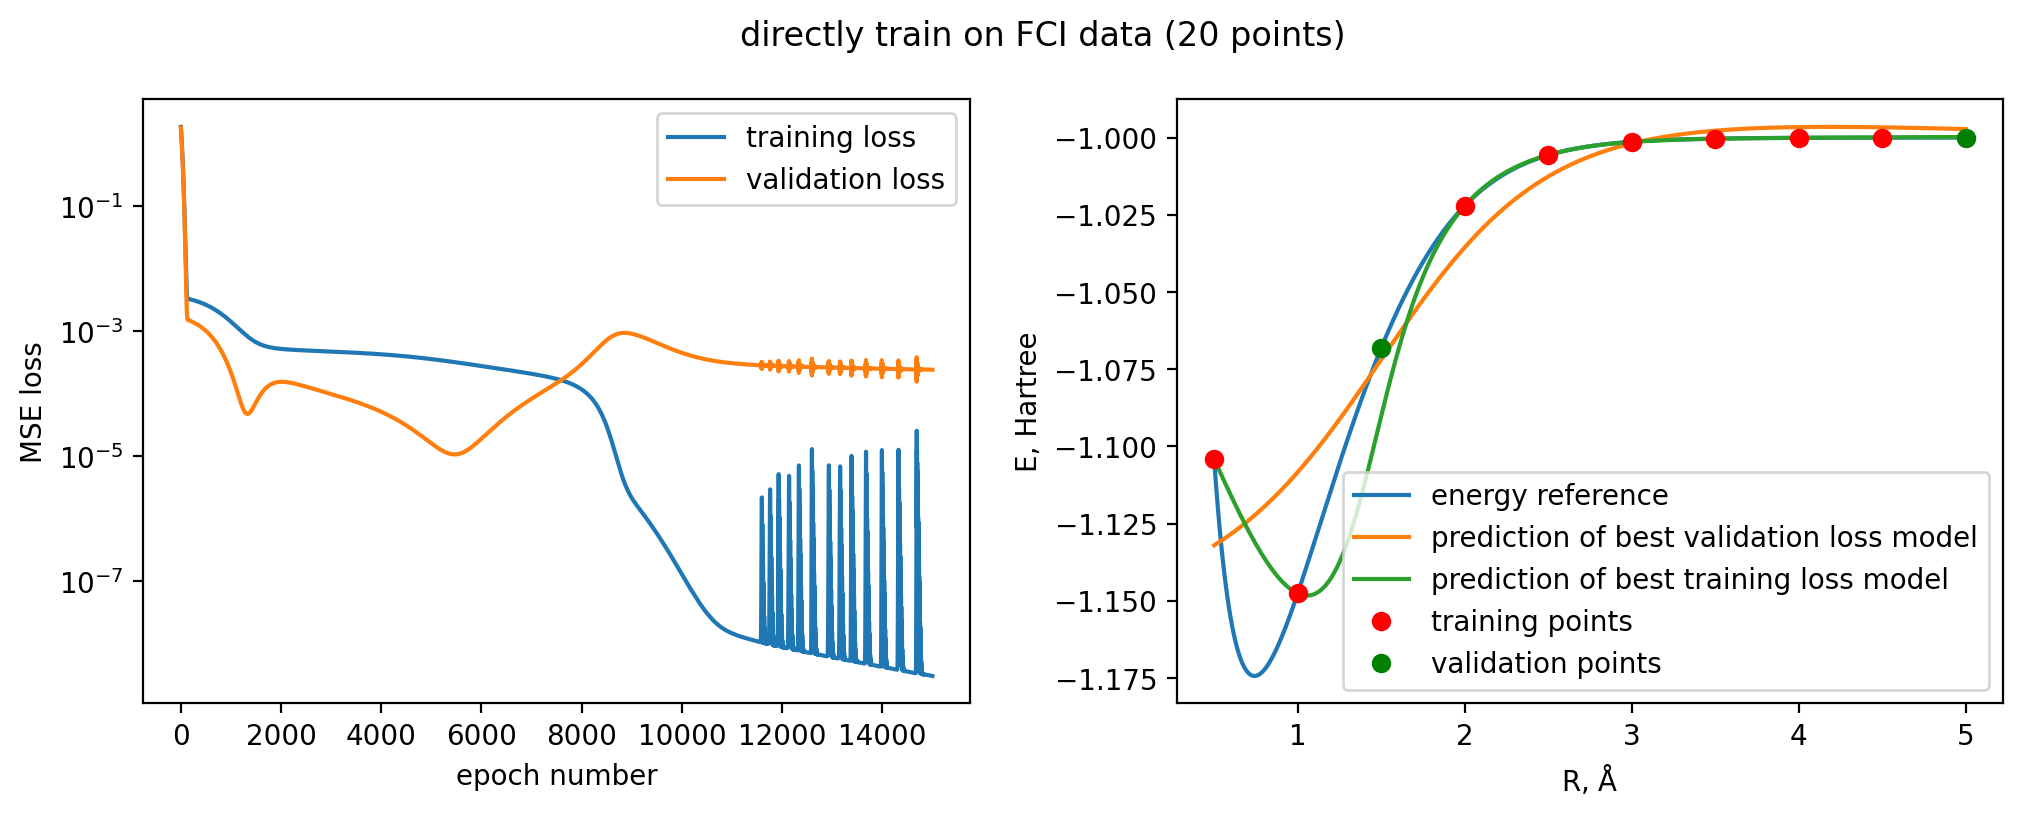

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
plt.subplots_adjust(wspace=0.25)
plt.suptitle('directly train on FCI data (20 points)')
plt.subplot(121)
plt.plot(train_loss_direct, label='training loss')
plt.plot(val_loss_direct, label='validation loss')
plt.xlabel('epoch number'); plt.ylabel('MSE loss')
plt.gca().set_yscale('log')
plt.legend()

plt.subplot(122)
plt.xlabel(r'R, $\mathrm{\AA}$ ')
plt.ylabel('E, Hartree')
plt.plot(R, E_FCI, label='energy reference')
plt.plot(R.reshape(-1), 
         direct_model(torch.from_numpy(R).reshape(-1, 1)).detach().numpy(),
         label='prediction of best validation loss model')
plt.plot(R.reshape(-1), 
         direct_model_train(torch.from_numpy(R).reshape(-1, 1)).detach().numpy(),
         label='prediction of best training loss model')
plt.plot(r_fci_train, e_fci_train, 'ro', label='training points')
plt.plot(r_fci_val, e_fci_val, 'go', label='validation points')
plt.plot()
plt.legend()

# Transfer Learning

## train on UHF data

In [ ]:
torch.manual_seed(1)
tl_model = NN(1, 16, 32, 16, 1)
_, tl_model, train_loss_uhf, val_loss_uhf = train(tl_model, uhf_train_ds, 
                                     x_val=r_uhf_val, y_val=e_uhf_val, 
                                     batch_size=64, epoch_num=10000)

epoch: 1000 train loss: 9.6929e-05 	 validate loss: 9.2287e-05
epoch: 2000 train loss: 5.2958e-05 	 validate loss: 3.7858e-05
epoch: 3000 train loss: 8.7449e-06 	 validate loss: 6.2395e-06
epoch: 4000 train loss: 8.4984e-07 	 validate loss: 4.5560e-07
epoch: 5000 train loss: 1.1534e-06 	 validate loss: 5.1399e-07
epoch: 6000 train loss: 1.5742e-06 	 validate loss: 5.3154e-07
epoch: 7000 train loss: 1.6185e-07 	 validate loss: 6.0082e-07
epoch: 8000 train loss: 3.3754e-07 	 validate loss: 2.4195e-07
epoch: 9000 train loss: 5.6671e-07 	 validate loss: 1.6477e-07
epoch: 10000 train loss: 2.4494e-07 	 validate loss: 2.2367e-07

  best train loss model: 	 train loss: 6.0212e-08 	 validate loss: 1.0089e-07

  best validation loss model: 	 train loss: 1.4454e-07 	 validate loss: 6.1022e-08


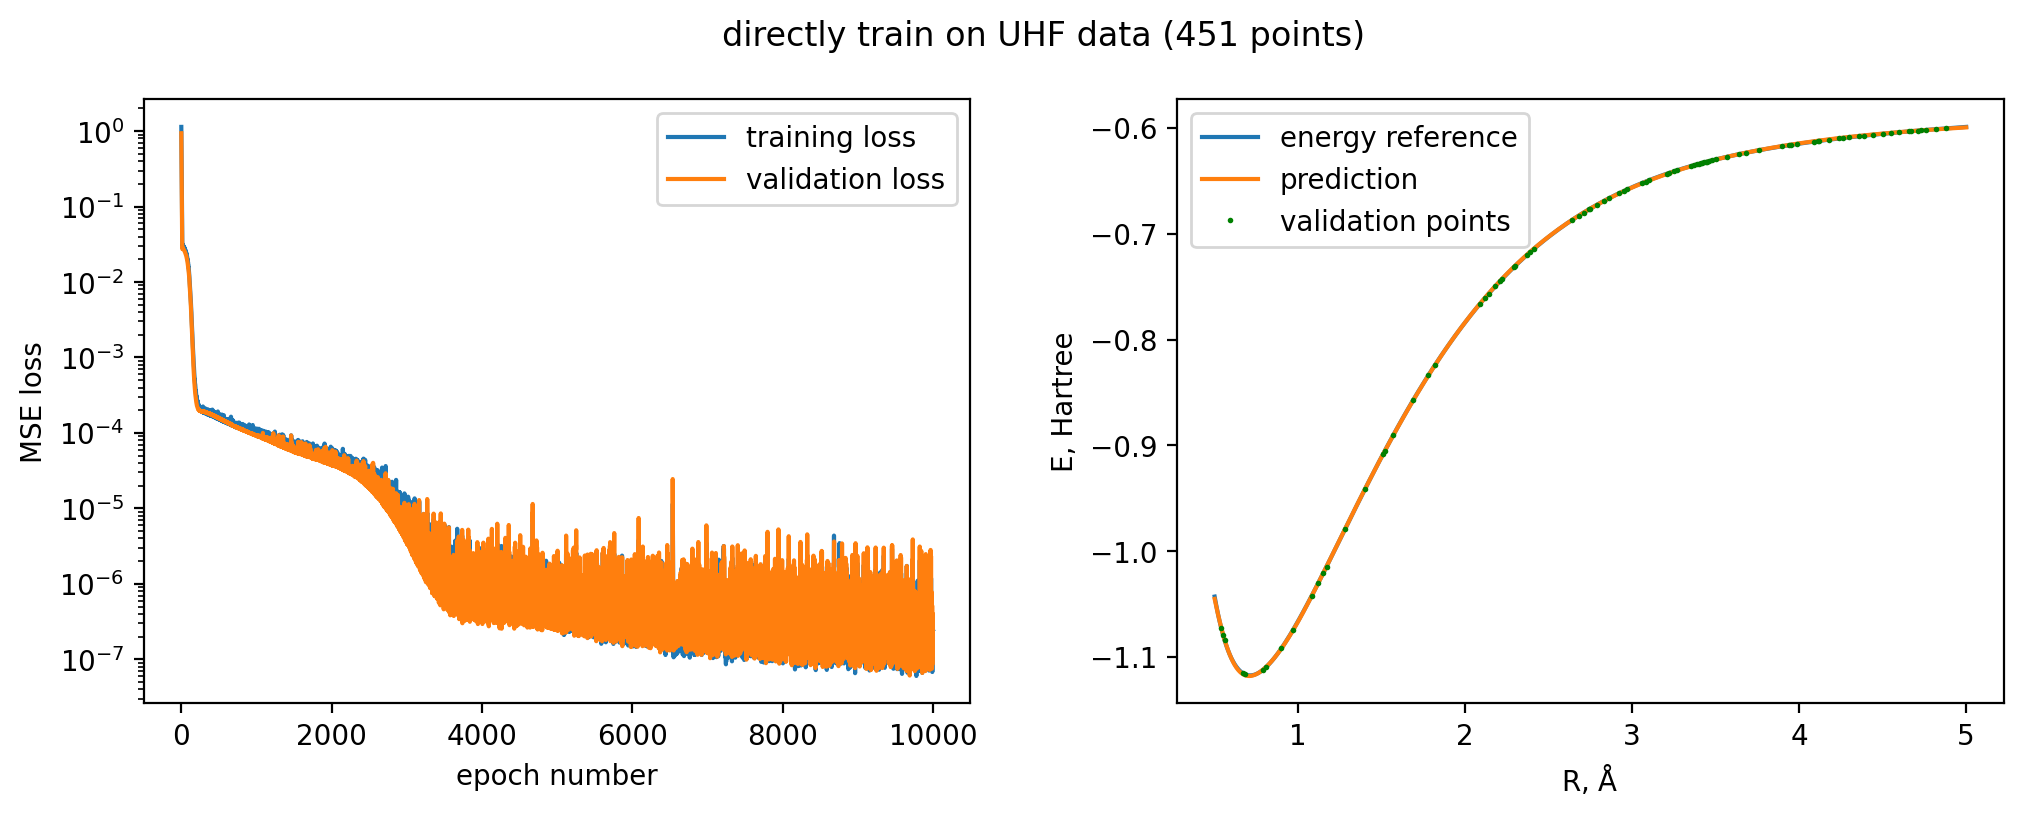

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
plt.subplots_adjust(wspace=0.25)
plt.suptitle('directly train on UHF data (451 points)')
plt.subplot(121)
plt.plot(train_loss_uhf, label='training loss')
plt.plot(val_loss_uhf, label='validation loss')
plt.xlabel('epoch number'); plt.ylabel('MSE loss')
plt.gca().set_yscale('log')
plt.legend()

plt.subplot(122)
plt.xlabel(r'R, $\mathrm{\AA}$ ')
plt.ylabel('E, Hartree')
plt.plot(R, E_UHF, label='energy reference')
plt.plot(R.reshape(-1), 
         tl_model(torch.from_numpy(R).reshape(-1, 1)).detach().numpy(),
         label='prediction')
plt.plot(r_uhf_val, e_uhf_val, 'go', markersize=1, label='validation points')
plt.legend()

## trainsfer learning

In [ ]:
print('the model parameter on current model')
for name, value in tl_model.named_parameters():
    print(f'name: {name} \t {value.shape} \t train_param: {value.requires_grad}')

the model parameter on current model
name: model.0.weight 	 torch.Size([16, 1]) 	 train_param: True
name: model.0.bias 	 torch.Size([16]) 	 train_param: True
name: model.2.weight 	 torch.Size([32, 16]) 	 train_param: True
name: model.2.bias 	 torch.Size([32]) 	 train_param: True
name: model.4.weight 	 torch.Size([16, 32]) 	 train_param: True
name: model.4.bias 	 torch.Size([16]) 	 train_param: True
name: model.6.weight 	 torch.Size([1, 16]) 	 train_param: True
name: model.6.bias 	 torch.Size([1]) 	 train_param: True


In [ ]:
def fix_param(model, fixed_param_name_list):
    for name, value in model.named_parameters():
        for fixed_name in fixed_param_name_list:
            if fixed_name in name:
                value.requires_grad = False

def unfix_param(model):
    for name, value in model.named_parameters():
        value.requires_grad = True

In [ ]:
tl_model_backup = deepcopy(tl_model)

In [ ]:
tl_model = tl_model_backup

In [ ]:
fixed_param_name_list = ['model.0', 'model.6']
fix_param(tl_model, fixed_param_name_list)
print('parameter status after fixing parameter')
for name, value in tl_model.named_parameters():
    print(f'name: {name} \t {value.shape} \t train_param: {value.requires_grad}')

parameter status after fixing parameter
name: model.0.weight 	 torch.Size([16, 1]) 	 train_param: False
name: model.0.bias 	 torch.Size([16]) 	 train_param: False
name: model.2.weight 	 torch.Size([32, 16]) 	 train_param: True
name: model.2.bias 	 torch.Size([32]) 	 train_param: True
name: model.4.weight 	 torch.Size([16, 32]) 	 train_param: True
name: model.4.bias 	 torch.Size([16]) 	 train_param: True
name: model.6.weight 	 torch.Size([1, 16]) 	 train_param: False
name: model.6.bias 	 torch.Size([1]) 	 train_param: False


In [ ]:
torch.manual_seed(1)
_, tl_model, train_loss_tl, val_loss_tl = train(tl_model, fci_train_ds, 
                                   x_val=r_fci_val, y_val=e_fci_val, 
                                   batch_size=64, epoch_num=50000, epoch_cycle_print=5000)

epoch: 5000 train loss: 7.5041e-09 	 validate loss: 8.5940e-06
epoch: 10000 train loss: 5.9228e-08 	 validate loss: 4.2465e-06
epoch: 15000 train loss: 6.5606e-10 	 validate loss: 4.2420e-06
epoch: 20000 train loss: 1.6279e-09 	 validate loss: 3.8712e-06
epoch: 25000 train loss: 5.2081e-10 	 validate loss: 3.5230e-06
epoch: 30000 train loss: 4.6550e-10 	 validate loss: 3.2273e-06
epoch: 35000 train loss: 1.5733e-07 	 validate loss: 5.1584e-06
epoch: 40000 train loss: 4.1028e-10 	 validate loss: 2.6947e-06
epoch: 45000 train loss: 3.2504e-10 	 validate loss: 2.4611e-06
epoch: 50000 train loss: 2.8821e-10 	 validate loss: 2.2314e-06

  best train loss model: 	 train loss: 2.8560e-10 	 validate loss: 2.2255e-06

  best validation loss model: 	 train loss: 1.4417e-06 	 validate loss: 7.9814e-07


In [ ]:
unfix_param(tl_model) 

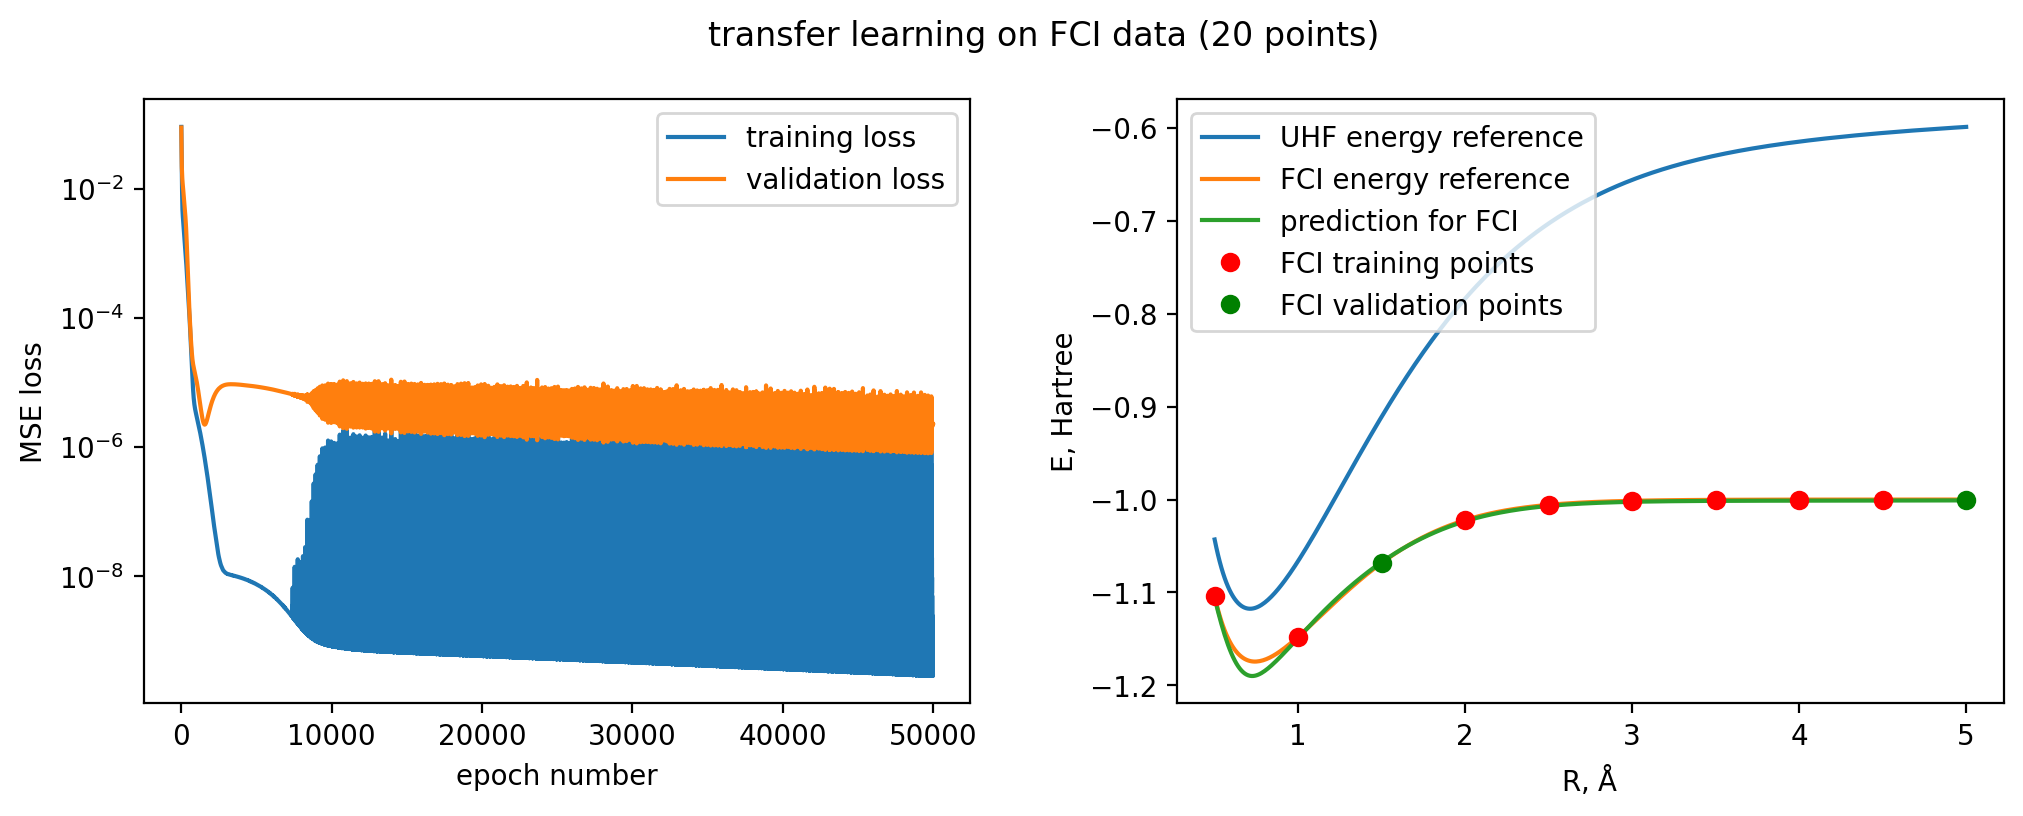

In [ ]:
plt.figure(figsize=(12, 4), dpi=200)
plt.subplots_adjust(wspace=0.25)
plt.suptitle('transfer learning on FCI data (20 points)')
plt.subplot(121)
plt.plot(train_loss_tl, label='training loss')
plt.plot(val_loss_tl, label='validation loss')
plt.xlabel('epoch number'); plt.ylabel('MSE loss')
plt.gca().set_yscale('log')
plt.legend()

plt.subplot(122)
plt.xlabel(r'R, $\mathrm{\AA}$ ')
plt.ylabel('E, Hartree')
plt.plot(R, E_UHF, label='UHF energy reference')
plt.plot(R, E_FCI, label='FCI energy reference')
plt.plot(R.reshape(-1), 
         tl_model(torch.from_numpy(R).reshape(-1, 1)).detach().numpy(),
         label='prediction for FCI')
plt.plot(r_fci_train, e_fci_train, 'ro', label='FCI training points')
plt.plot(r_fci_val, e_fci_val, 'go', label='FCI validation points')
plt.legend()

# Comparing

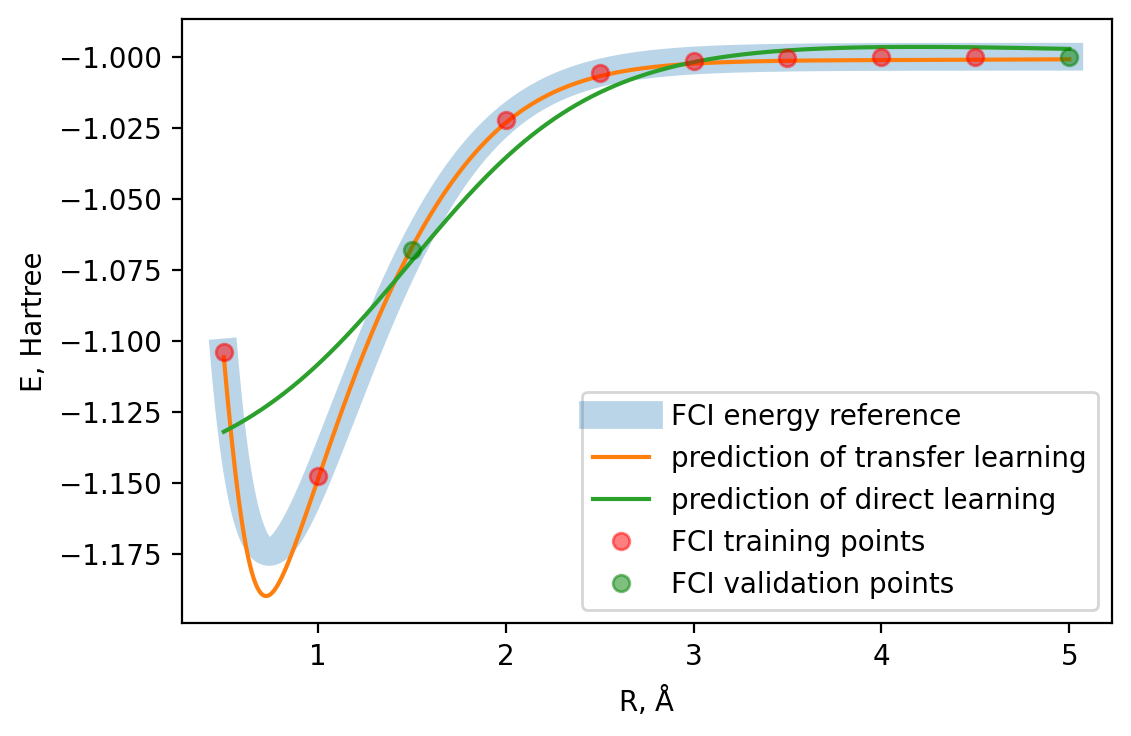

In [ ]:
plt.figure(figsize=(6, 4), dpi=200)
# plt.suptitle('result compare between directing training and transfer learning')
plt.xlabel(r'R, $\mathrm{\AA}$ ')
plt.ylabel('E, Hartree')

plt.plot(R, E_FCI, lw=10, alpha=0.3, label='FCI energy reference')
plt.plot(R.reshape(-1), 
         tl_model(torch.from_numpy(R).reshape(-1, 1)).detach().numpy(),
         label='prediction of transfer learning')
plt.plot(R.reshape(-1), 
         direct_model(torch.from_numpy(R).reshape(-1, 1)).detach().numpy(),
         label='prediction of direct learning')
plt.plot(r_fci_train, e_fci_train, 'ro', alpha=0.5, label='FCI training points')
plt.plot(r_fci_val, e_fci_val, 'go', alpha=0.5, label='FCI validation points')
plt.legend()
plt.savefig('compare_direct_TL_model.jpg', bbox_inches='tight')